A common problem in high-availability systems is how much resources to provide: how to ensure stability reducing the spending? A solution is auto-scaling: a system component that increases or decreases de amount of resources used by the system according to the current needs. But for that, we need to have an idea of how many requests will arrive. This is an interesting problem to model statistically.

Consider an employee portal. It is almost never accessed outside the work hours. During working hours , it usually has a predictably mild number of access during most of the workdays of the month. In the last working day of month, however, it have a spike of access from employees looking for correcting clock-in registrations that may be missing. Then, on the latest working day before or equal to 5, there is another spike, since employees receive their payment this day and want to check their payslip.

If we consider access in general as defined by a Poisson process, we can consider choosing a nonhomogeneous Poisson distribution.

Let's consider a scenario where we have 1 request per five minutes outside office hours. IN office hours, we have around 100 request per minute, except on the last day of the month, when it goes to 800 requests per minute, and on day 5, when it goes to 500 requests per minute. In this case, the rate function $\lambda$ responds for the day of the month:

In [65]:
import pandas as pd
from brandedpipes import __

from datetime import datetime, timedelta
from time import strptime

def base_rate_function(
        date,
        outside_office_hours_rate=0.2,
        office_hours_rate=100,
        payday_rate=500,
        clockin_rate=800,
    ):
    """
    Return the rate of access to the web app per minute for every day.

    It is very low outside business days...

    >>> base_rate_function(D('2024-05-11 9:40'))
    0.2

    ...and business hours:

    >>> base_rate_function(D('2024-12-19 7:00'))
    0.2

    Usually it is quite mild during office hours:

    >>> base_rate_function(D('2024-12-19 9:40'))
    100

    Every payday (day 5 or earliest), though, it spikes to 500 req/minute:

    >>> base_rate_function(D('2024-11-05 12:55'))
    500
    >>> base_rate_function(D('2024-10-04 12:59'))
    500

    In the last workday of the month, it spikes to 800 reqs/minunte due to
    clock-in adjustments

    >>> base_rate_function(D('2024-02-29 10:00'))
    800
    >>> base_rate_function(D('2024-6-28 10:00'))
    800
    """
    if not is_office_hours(date):
        return outside_office_hours_rate
    if is_last_business_day_wrt(date, 5):
        return payday_rate
    if is_last_business_day_wrt(date, last_day_of_month(date)):
        return clockin_rate
    return office_hours_rate

office_hours_start=8
office_hours_end=18

def is_office_hours(date):
    if not is_business_day(date):
        return False
    if date.hour < office_hours_start:
        return False
    if date.hour > office_hours_end-1:
        return False
    return True

def last_day_of_month(date):
    """
    >>> last_day_of_month(D('2012-02-14'))
    29
    """
    first_day_current_month = datetime(date.year, date.month, 1)
    next_month = first_day_current_month + timedelta(days=31)
    first_day_next_month = datetime(next_month.year, next_month.month, 1)
    return previous_day(first_day_next_month).day

def is_last_business_day_wrt(date, day):
    """
    Receives a date and a day of the month. Returns true if
    the date is the day and is also a business day:

    >>> is_last_business_day_wrt(D('2025-09-05'), 5)
    True

    If the date is not in that day of the month, and in that
    month the given day is not a business day, it returns
    True if the given date is the last business day before
    the given day:

    >>> is_last_business_day_wrt(D('2024-10-04'), 5)
    True
    >>> is_last_business_day_wrt(D('2025-09-5'), 7)
    True

    It will return false if the date is not a business day...

    >>> is_last_business_day_wrt(D('2024-10-5'), 5)
    False

    ...or if it is not the given day of the month:

    >>> is_last_business_day_wrt(D('2024-10-3'), 4)
    False
    """
    if not is_business_day(date):
        return False
    if date.day == day:
        return True
    nd = next_day(date)
    while not is_business_day(nd):
        if nd.day == day:
            return True
        nd = next_day(nd)
    return False

def is_business_day(date):
    """
    Returns true if the date is a business date (not considering holidays):

    >>> is_business_day(D('2025-09-05'))
    True
    >>> is_business_day(D('2025-09-06'))
    False
    """
    workdays = pd.bdate_range(start=date, end=date)
    return __| workdays | len | bool |__

def previous_day(date):
    return date + timedelta(days=-1)

def next_day(date):
    return date + timedelta(days=1)

def D(s):
    """
    For testing and debug only.
    """
    try:
        sd = strptime(s, '%Y-%m-%d %H:%M')
    except ValueError as e:
        sd = strptime(s, '%Y-%m-%d')
    return datetime(*sd[:5])

With that, we can simulate the behavior over a long period of time (let's say, two months) to try to observe patterns:

8


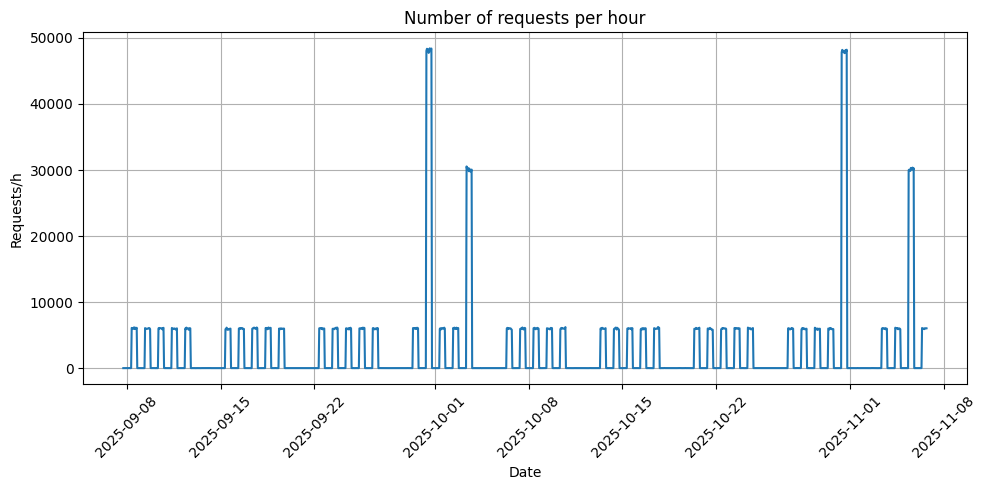

In [66]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_requests(start_time, horizon, interval_size, rate_function=base_rate_function, **kwargs):
    events = {}
    
    for t in range(horizon):
        interval_start = start_time + timedelta(hours=t)
        rate = rate_function(interval_start, **kwargs) * interval_size
        events[interval_start] = np.random.poisson(rate)

    # Sort the dictionary by datetime keys to ensure correct order
    return events

def plot_simulation(events, marker=None):
    sorted_items = sorted(events.items())
    dates = [item[0] for item in sorted_items]
    values = [item[1] for item in sorted_items]
    plt.figure(figsize=(10, 5))
    plt.plot(dates, values, marker=marker, markerfacecolor='red', linestyle='-')
    plt.xlabel('Date')
    plt.ylabel('Requests/h')
    plt.title('Number of requests per hour')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

HOUR = 60

# Three months, more or less
horizon = 60*24

start_time = datetime.now()

event_simulation = simulate_requests(datetime.now(), horizon, HOUR)
__| event_simulation.values() | iter | next | print |__
plot_simulation(event_simulation)

Now let us observe a smaller interval, so we can see more clearly how it behaves locally:

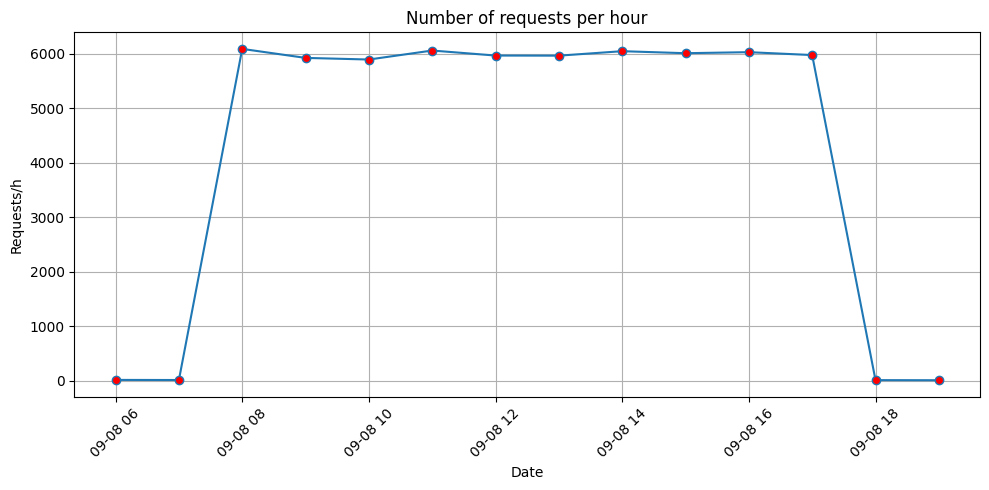

In [67]:
# One day
horizon = 14

start_time = D('2025-09-08 06:00')

event_simulation = simulate_requests(start_time, horizon, HOUR)
plot_simulation(event_simulation, marker='o')


We can notice the jump in the number of requests is quite steep. In reality, it is usually smoothier. We can alleviate this issue by making the rate a random variable that tends to be lower closer to the edges of the office hours. We can do it by multiplying the base rate by a factor that grows over the time — e.g. by generating such factor through a Gaussian function:

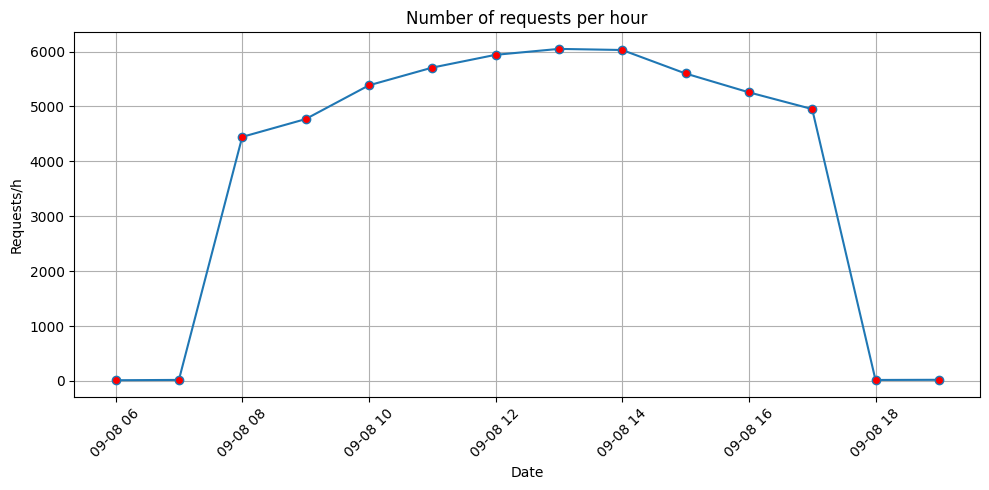

In [69]:
def smooth_rate_function(date, *args, sd=1, **kwargs):
    base_rate = base_rate_function(date, *args, **kwargs)
    if is_office_hours(date):
        base_rate *= smoothing_factor(date.hour)
    return base_rate


def smoothing_factor(hour, spread=0.025):
    """
    The default spread value of 0.05 was found by manual experimentation.
    We wanted one that would give a factor of around 75% closer to the 
    limits of the office hours.
    
    >>> smoothing_factor(13)
    np.float64(1.0)
    >>> 0.75 - smoothing_factor(office_hours_start) < 0.05
    np.True_
    >>> 0.75 - smoothing_factor(office_hours_end) < 0.05
    np.True_
    """
    hour = hour - office_hours_start
    work_day_length = office_hours_end - office_hours_start
    peak = work_day_length / 2
    return np.exp(-(hour-peak)**2/2*spread)

horizon = 14

start_time = D('2025-09-08 06:00')

event_simulation = simulate_requests(start_time, horizon, HOUR, rate_function=smooth_rate_function, sd=4)
plot_simulation(event_simulation, marker='o')


This model has some limitations, though, two of which are of special concern for us:

- The change between the times is too abrupt. Given our interest in forecasting requests for auto-scaling, which should respond in minutes, this would impact our success.
- Request arrival rates are not totally independent. While one request does not imply another one would happen, the happensance of a request suggests an exogenous event that led to it, and could lead to more. (For example, someone sending a message to colleagues to check new info in the intranet.)

We can address the second issue by extending our code to model a [Hawkes process](https://hawkeslib.readthedocs.io/en/latest/tutorial.html). While this is more fit for self-exciting processes, we theorize it can be a reasonable model for our problem. It also should address a bit the issue of smoothness.

In [70]:
import doctest
doctest.testmod()


TestResults(failed=0, attempted=18)